In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [51]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpxsmuwade\tensorboard_logs


In [3]:
gz = keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
FEATURES = 28

In [5]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [6]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


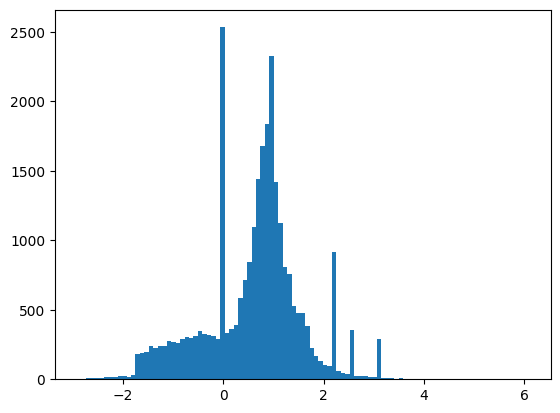

In [8]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [9]:
N_VALIDATION = int(1e3)

In [10]:
N_VALIDATION

1000

In [11]:
N_TRAIN = int(1e4)

In [12]:
N_TRAIN

10000

In [13]:
BUFFER_SIZE = int(1e4)

In [14]:
BATCH_SIZE = 500

In [15]:
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [16]:
STEPS_PER_EPOCH

20

In [17]:
validate_ds = packed_ds.take(N_VALIDATION).cache()

In [18]:
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [19]:
validate_ds = validate_ds.batch(BATCH_SIZE)

In [20]:
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [21]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

In [22]:
def get_optimizer():
    return keras.optimizers.Adam(lr_schedule)

In [23]:
step = np.linspace(0, 100000)

In [24]:
step

array([     0.        ,   2040.81632653,   4081.63265306,   6122.44897959,
         8163.26530612,  10204.08163265,  12244.89795918,  14285.71428571,
        16326.53061224,  18367.34693878,  20408.16326531,  22448.97959184,
        24489.79591837,  26530.6122449 ,  28571.42857143,  30612.24489796,
        32653.06122449,  34693.87755102,  36734.69387755,  38775.51020408,
        40816.32653061,  42857.14285714,  44897.95918367,  46938.7755102 ,
        48979.59183673,  51020.40816327,  53061.2244898 ,  55102.04081633,
        57142.85714286,  59183.67346939,  61224.48979592,  63265.30612245,
        65306.12244898,  67346.93877551,  69387.75510204,  71428.57142857,
        73469.3877551 ,  75510.20408163,  77551.02040816,  79591.83673469,
        81632.65306122,  83673.46938776,  85714.28571429,  87755.10204082,
        89795.91836735,  91836.73469388,  93877.55102041,  95918.36734694,
        97959.18367347, 100000.        ])

In [25]:
lr = lr_schedule(step)

In [27]:
lr

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.001     , 0.00090741, 0.00083051, 0.00076563, 0.00071014,
       0.00066216, 0.00062025, 0.00058333, 0.00055056, 0.00052128,
       0.00049495, 0.00047115, 0.00044954, 0.00042982, 0.00041176,
       0.00039516, 0.00037984, 0.00036567, 0.00035252, 0.00034028,
       0.00032886, 0.00031818, 0.00030818, 0.00029878, 0.00028994,
       0.00028161, 0.00027374, 0.0002663 , 0.00025926, 0.00025258,
       0.00024623, 0.0002402 , 0.00023445, 0.00022897, 0.00022374,
       0.00021875, 0.00021397, 0.0002094 , 0.00020502, 0.00020082,
       0.00019679, 0.00019291, 0.00018919, 0.00018561, 0.00018216,
       0.00017883, 0.00017563, 0.00017254, 0.00016955, 0.00016667],
      dtype=float32)>

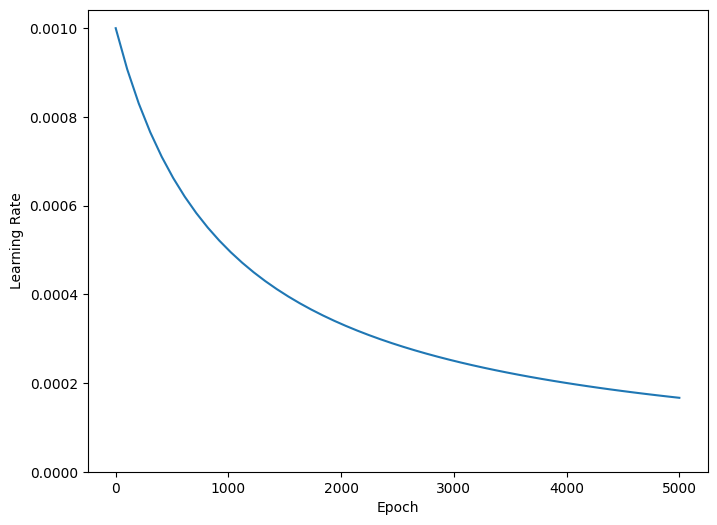

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [29]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        keras.callbacks.TensorBoard(logdir/name)
    ]

In [34]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.metrics.BinaryCrossentropy(
                          from_logits=True, name='binary_crossentropy'),
                      'accuracy'])

    model.summary()

    history = model.fit(
        train_ds.map(lambda x, y: (x, tf.expand_dims(y, axis=-1))),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds.map(
            lambda x, y: (x, tf.expand_dims(y, axis=-1))),
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [35]:
# tiny model
tiny_model = keras.Sequential([
    keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(1)
])

In [36]:
size_histories = {}

In [ ]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4870,  binary_crossentropy:0.8518,  loss:0.8518,  val_accuracy:0.4350,  val_binary_crossentropy:0.8285,  val_loss:0.8285,  
.....

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


...............................................................................................
Epoch: 100, accuracy:0.5880,  binary_crossentropy:0.6333,  loss:0.6333,  val_accuracy:0.5740,  val_binary_crossentropy:0.6338,  val_loss:0.6338,  
....................................................................................................
Epoch: 200, accuracy:0.6091,  binary_crossentropy:0.6227,  loss:0.6227,  val_accuracy:0.5800,  val_binary_crossentropy:0.6288,  val_loss:0.6288,  
....................................................................................................
Epoch: 300, accuracy:0.6202,  binary_crossentropy:0.6146,  loss:0.6146,  val_accuracy:0.5920,  val_binary_crossentropy:0.6252,  val_loss:0.6252,  
....................................................................................................
Epoch: 400, accuracy:0.6311,  binary_crossentropy:0.6069,  loss:0.6069,  val_accuracy:0.6190,  val_binary_crossentropy:0.6177,  val_loss:0.6177,  
.............

(0.5, 0.7)

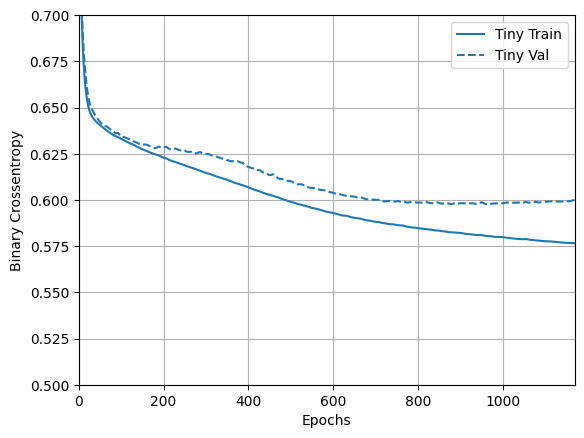

In [38]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [40]:
small_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(16, activation='elu'),
    keras.layers.Dense(1)
])

d:\code\selenium\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4882,  binary_crossentropy:0.8030,  loss:0.8030,  val_accuracy:0.4830,  val_binary_crossentropy:0.7494,  val_loss:0.7494,  
....

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


................................................................................................
Epoch: 100, accuracy:0.6165,  binary_crossentropy:0.6180,  loss:0.6180,  val_accuracy:0.5860,  val_binary_crossentropy:0.6297,  val_loss:0.6297,  
....................................................................................................
Epoch: 200, accuracy:0.6432,  binary_crossentropy:0.6021,  loss:0.6021,  val_accuracy:0.6250,  val_binary_crossentropy:0.6213,  val_loss:0.6213,  
....................................................................................................
Epoch: 300, accuracy:0.6564,  binary_crossentropy:0.5883,  loss:0.5883,  val_accuracy:0.6250,  val_binary_crossentropy:0.6107,  val_loss:0.6107,  
....................................................................................................
Epoch: 400, accuracy:0.6770,  binary_crossentropy:0.5791,  loss:0.5791,  val_accuracy:0.6550,  val_binary_crossentropy:0.6019,  val_loss:0.6019,  
............

In [44]:
medium_model = keras.Sequential([
    keras.layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(1)
])

d:\code\selenium\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5052,  binary_crossentropy:0.6873,  loss:0.6873,  val_accuracy:0.4920,  val_binary_crossentropy:0.6712,  val_loss:0.6712,  
....

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


................................................................................................
Epoch: 100, accuracy:0.7154,  binary_crossentropy:0.5328,  loss:0.5328,  val_accuracy:0.6480,  val_binary_crossentropy:0.6103,  val_loss:0.6103,  
....................................................................................................
Epoch: 200, accuracy:0.7911,  binary_crossentropy:0.4293,  loss:0.4293,  val_accuracy:0.6350,  val_binary_crossentropy:0.6929,  val_loss:0.6929,  
.....................................................................................

In [47]:
large_model = keras.Sequential([
    keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(1)
])

d:\code\selenium\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5162,  binary_crossentropy:0.7653,  loss:0.7653,  val_accuracy:0.4900,  val_binary_crossentropy:0.6677,  val_loss:0.6677,  
.

C:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


...................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0020,  loss:0.0020,  val_accuracy:0.6520,  val_binary_crossentropy:1.8491,  val_loss:1.8491,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6540,  val_binary_crossentropy:2.5047,  val_loss:2.5047,  
.........................

Text(0.5, 0, 'Epochs [Log Scale]')

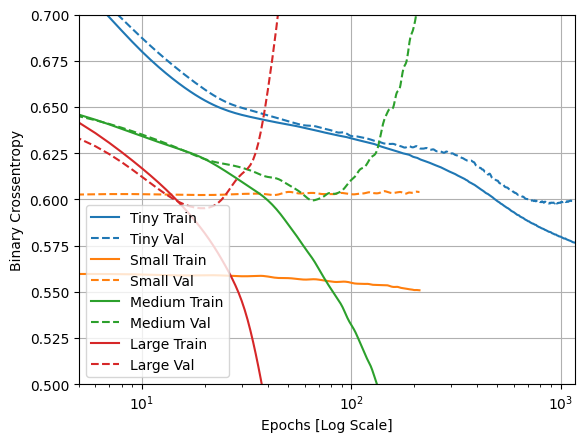

In [49]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [52]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpxsmuwade\tensorboard_logs


`tf.stack` trong TensorFlow là hàm giúp xếp chồng các tensor lại với nhau dọc theo một chiều mới (được chỉ định bởi tham số `axis`). Điều này có nghĩa là nó tạo ra một tensor mới có một chiều lớn hơn tensor ban đầu.

### Cách Hoạt Động của `tf.stack`
Hàm `tf.stack` kết hợp một danh sách các tensor có cùng shape lại với nhau để tạo ra một tensor mới có shape lớn hơn.

- **Tham số `axis`** xác định chiều mà các tensor sẽ được xếp chồng. Khi `axis=0`, các tensor được xếp chồng thành một chiều mới đầu tiên (tương đương với việc thêm một chiều mới ở đầu). Khi `axis=1`, chiều mới sẽ được thêm vào vị trí thứ hai, và cứ tiếp tục như vậy.

### Giải Thích `axis`
Giả sử có hai tensor `a` và `b` có shape `(3,)`:
```python
a = tf.constant([1, 2, 3])
b = tf.constant([4, 5, 6])
```
- **axis=0**: Thêm một chiều mới ở đầu (tạo thành một "batch"):
  ```python
  tf.stack([a, b], axis=0)
  ```
  Output:
  ```
  [[1, 2, 3],
   [4, 5, 6]]
  ```
  Shape của tensor mới: `(2, 3)`.

- **axis=1**: Thêm một chiều mới vào vị trí thứ hai (tạo thành cột):
  ```python
  tf.stack([a, b], axis=1)
  ```
  Output:
  ```
  [[1, 4],
   [2, 5],
   [3, 6]]
  ```
  Shape của tensor mới: `(3, 2)`.

### Ví dụ Với Tensor 2D
Nếu `a` và `b` có shape `(2, 3)`:
```python
a = tf.constant([[1, 2, 3], [4, 5, 6]])
b = tf.constant([[7, 8, 9], [10, 11, 12]])
```

- **axis=0**:
  ```python
  tf.stack([a, b], axis=0)
  ```
  Output:
  ```
  [[[ 1,  2,  3],
    [ 4,  5,  6]],

   [[ 7,  8,  9],
    [10, 11, 12]]]
  ```
  Shape của tensor mới: `(2, 2, 3)`.

- **axis=1**:
  ```python
  tf.stack([a, b], axis=1)
  ```
  Output:
  ```
  [[[ 1,  2,  3],
    [ 7,  8,  9]],

   [[ 4,  5,  6],
    [10, 11, 12]]]
  ```
  Shape của tensor mới: `(2, 2, 3)`.

### Tóm Lại
- `axis=0` xếp tensor theo chiều "batch" (thêm một chiều ở đầu).
- `axis=1` xếp tensor theo chiều tiếp theo, giữ nguyên batch đầu tiên.



**Dịch**:

Trái ngược với quá khớp (overfitting) là hiện tượng dưới khớp (underfitting). Dưới khớp xảy ra khi mô hình vẫn có thể cải thiện được trên dữ liệu huấn luyện. Điều này có thể xảy ra vì một số lý do: khi mô hình không đủ mạnh, bị điều chuẩn quá mức hoặc đơn giản là chưa được huấn luyện đủ lâu. Điều này có nghĩa là mạng chưa học được các mẫu liên quan trong dữ liệu huấn luyện.

**Giải thích**:

- **Underfitting (dưới khớp)** xảy ra khi mô hình chưa đạt được hiệu quả cần thiết ngay cả trên dữ liệu huấn luyện. Nghĩa là, mô hình còn dư địa để cải thiện và có thể làm tốt hơn nếu được điều chỉnh.

- **Các nguyên nhân**:
  - **Mô hình không đủ mạnh**: Mô hình có thể quá đơn giản, chưa đủ phức tạp để học các mẫu từ dữ liệu.
  - **Điều chuẩn quá mức** (over-regularization): Các kỹ thuật điều chuẩn (như dropout hoặc regularization) nếu sử dụng quá mức có thể ngăn mô hình học đủ chi tiết từ dữ liệu.
  - **Thời gian huấn luyện chưa đủ**: Nếu mô hình chưa được huấn luyện đủ số lần (epochs), nó sẽ chưa kịp học hết các đặc trưng của dữ liệu.

Khi xảy ra underfitting, mô hình không nắm bắt được các mẫu quan trọng trong dữ liệu huấn luyện, do đó cả hiệu suất trên dữ liệu huấn luyện và dữ liệu kiểm tra đều thấp.

**Dịch**:

Để ngăn chặn hiện tượng quá khớp (overfitting), giải pháp tốt nhất là sử dụng dữ liệu huấn luyện đầy đủ hơn. Tập dữ liệu nên bao quát toàn bộ các đầu vào mà mô hình dự kiến sẽ xử lý. Dữ liệu bổ sung chỉ có thể hữu ích nếu nó bao gồm các trường hợp mới và thú vị.

**Giải thích**:

- **Ngăn chặn quá khớp** (overfitting): Quá khớp xảy ra khi mô hình học quá mức các đặc trưng của dữ liệu huấn luyện, dẫn đến hiệu suất kém trên dữ liệu kiểm tra (dữ liệu chưa thấy trước). Để ngăn chặn điều này, việc cung cấp dữ liệu huấn luyện phong phú và đa dạng là rất quan trọng.

- **Dữ liệu huấn luyện đầy đủ**: Dữ liệu cần phải bao quát toàn bộ các tình huống mà mô hình sẽ gặp phải trong thực tế. Nếu dữ liệu huấn luyện không đầy đủ, mô hình có thể không học được các mẫu cần thiết, dẫn đến tình trạng quá khớp.

- **Dữ liệu bổ sung**: Việc bổ sung dữ liệu mới chỉ thật sự hữu ích nếu nó mang lại các tình huống hoặc trường hợp mà mô hình chưa thấy trước đây. Những dữ liệu này có thể giúp mô hình học được nhiều đặc trưng hơn, từ đó cải thiện khả năng tổng quát (generalization) và hiệu suất trên dữ liệu chưa thấy.

**Dịch**:

Một mô hình được huấn luyện trên dữ liệu đầy đủ hơn sẽ tự nhiên tổng quát tốt hơn. Khi điều đó không còn khả thi, giải pháp tốt tiếp theo là sử dụng các kỹ thuật như chuẩn hóa (regularization). Những kỹ thuật này đặt ra các ràng buộc về số lượng và loại thông tin mà mô hình của bạn có thể lưu trữ. Nếu một mạng chỉ có thể ghi nhớ một số lượng mẫu nhỏ, quá trình tối ưu hóa sẽ buộc nó phải tập trung vào các mẫu nổi bật nhất, những mẫu này có khả năng tổng quát tốt hơn.

**Giải thích**:

- **Tổng quát tốt hơn**: Một mô hình được huấn luyện trên tập dữ liệu phong phú và đầy đủ sẽ có khả năng áp dụng tốt hơn cho dữ liệu chưa thấy, tức là nó có thể đưa ra dự đoán chính xác hơn cho các trường hợp khác nhau.

- **Kỹ thuật chuẩn hóa**: Khi không thể mở rộng tập dữ liệu hoặc khi dữ liệu hiện có vẫn không đủ, các kỹ thuật như chuẩn hóa trở nên cần thiết. Chuẩn hóa giúp ngăn chặn hiện tượng quá khớp bằng cách giới hạn số lượng thông tin mà mô hình có thể ghi nhớ.

- **Ràng buộc về mẫu**: Nếu mô hình chỉ có khả năng ghi nhớ một số lượng mẫu nhỏ, thì trong quá trình huấn luyện, nó sẽ được tối ưu hóa để chỉ tập trung vào các mẫu quan trọng và nổi bật nhất. Những mẫu này thường có khả năng tổng quát tốt hơn khi gặp dữ liệu mới, giúp mô hình hoạt động hiệu quả hơn trên các trường hợp chưa thấy.

**Dịch:** Trong học sâu, số lượng tham số có thể học được trong một mô hình thường được gọi là "khả năng" của mô hình.

**Giải thích:** 

Trong một mô hình học sâu (deep learning), *capacity* hay "khả năng" đề cập đến khả năng của mô hình trong việc học và ghi nhớ các mối quan hệ trong dữ liệu. Số lượng tham số có thể học được—ví dụ như weights và biases trong các lớp mạng nơ-ron—sẽ quyết định khả năng này. Mô hình với nhiều tham số hơn có khả năng học các mẫu phức tạp hơn và điều chỉnh tốt hơn theo dữ liệu. Tuy nhiên, nếu số lượng tham số quá lớn so với dữ liệu, mô hình có thể bị *overfitting*, tức là học quá sát với dữ liệu huấn luyện và không tổng quát hóa tốt cho dữ liệu mới.



**Dịch:** Về mặt trực quan, một mô hình có nhiều tham số hơn sẽ có "khả năng ghi nhớ" cao hơn, và do đó sẽ dễ dàng học được một sự ánh xạ hoàn hảo kiểu từ điển giữa các mẫu huấn luyện và mục tiêu của chúng. Tuy nhiên, đây là một dạng ánh xạ không có sức mạnh tổng quát, và sẽ trở nên vô ích khi dự đoán trên dữ liệu chưa từng thấy trước đó.

**Giải thích:** 

Một mô hình có nhiều tham số sẽ có khả năng ghi nhớ rất tốt, cho phép nó "nhớ" chính xác từng mẫu trong tập dữ liệu huấn luyện và tạo một ánh xạ chính xác từ đầu vào đến đầu ra tương ứng. Tuy nhiên, khả năng ghi nhớ này không đồng nghĩa với khả năng tổng quát hóa. Khi một mô hình chỉ dựa vào ghi nhớ (memorization) mà thiếu tính tổng quát (generalization), nó sẽ không thể dự đoán chính xác khi gặp dữ liệu mới, vì nó không hiểu được các đặc trưng chung của dữ liệu. Trong học sâu, mục tiêu là mô hình phải có khả năng tổng quát hóa, tức là học được các quy luật chung để có thể đưa ra dự đoán chính xác trên cả dữ liệu chưa thấy trước đó.

**Dịch:** Luôn ghi nhớ điều này: các mô hình học sâu thường có khả năng phù hợp tốt với dữ liệu huấn luyện, nhưng thách thức thực sự là khả năng tổng quát hóa, chứ không phải chỉ là việc khớp với dữ liệu.

**Giải thích:**

Trong học sâu, các mô hình thường rất giỏi trong việc "học" và "nhớ" dữ liệu huấn luyện, nghĩa là chúng có thể dự đoán chính xác các đầu ra trên dữ liệu đã thấy trong quá trình huấn luyện. Tuy nhiên, việc chỉ học khớp với dữ liệu đã thấy không phải là mục tiêu cuối cùng, vì một mô hình như vậy có thể gặp khó khăn khi xử lý dữ liệu mới. Thách thức lớn nhất trong học sâu là làm sao để mô hình không chỉ ghi nhớ mà còn học được các đặc trưng chung, giúp nó dự đoán chính xác trên dữ liệu chưa gặp trước đó. Đây là yếu tố quan trọng để đánh giá hiệu quả của một mô hình khi áp dụng vào thực tế.

**Dịch:** Mặt khác, nếu mạng nơ-ron có tài nguyên ghi nhớ hạn chế, nó sẽ không dễ dàng học được mối quan hệ giữa dữ liệu đầu vào và đầu ra. Để giảm thiểu mất mát, mạng sẽ phải học các biểu diễn nén có khả năng dự đoán tốt hơn. Tuy nhiên, nếu mô hình quá nhỏ, nó sẽ gặp khó khăn trong việc khớp với dữ liệu huấn luyện. Có một sự cân bằng giữa "quá nhiều khả năng ghi nhớ" và "không đủ khả năng ghi nhớ."

**Giải thích:**

Câu này nói về sự cân bằng giữa kích thước của mô hình và khả năng dự đoán của nó. Khi mô hình có ít tham số (tài nguyên ghi nhớ hạn chế), nó phải nén và khái quát hóa dữ liệu để tìm ra các đặc trưng quan trọng, thay vì chỉ ghi nhớ. Điều này giúp mô hình có khả năng tổng quát hóa tốt hơn, vì nó phải học cách đơn giản hóa thông tin để dự đoán tốt hơn trên dữ liệu mới. Tuy nhiên, nếu mô hình quá nhỏ, nó sẽ không đủ "dung lượng" để ghi nhớ tất cả các chi tiết trong dữ liệu huấn luyện, dẫn đến việc không thể học tốt được cả trên tập huấn luyện lẫn dữ liệu mới. Vậy nên, cần điều chỉnh kích thước mô hình sao cho nó vừa đủ để học tốt dữ liệu huấn luyện, vừa có khả năng tổng quát hóa tốt trên dữ liệu chưa thấy.

**Dịch:** Thật không may, không có công thức kỳ diệu nào để xác định kích thước hay cấu trúc đúng đắn cho mô hình của bạn (về số lượng lớp, hoặc kích thước phù hợp cho mỗi lớp). Bạn sẽ phải thử nghiệm với một loạt các cấu trúc khác nhau.

**Giải thích:** 

Câu này nói lên thực tế trong việc thiết kế mô hình học sâu: không có quy tắc cố định nào để xác định trước số lớp hay số lượng nơ-ron cho mỗi lớp là “tốt nhất” cho mọi bài toán. Thay vào đó, người phát triển phải thử nghiệm nhiều kiến trúc khác nhau, điều chỉnh các thành phần của mô hình để tìm ra cấu trúc mang lại kết quả tốt nhất trên dữ liệu cụ thể. Mỗi bài toán có đặc điểm riêng, và do đó đòi hỏi một mô hình có cấu trúc phù hợp với các yêu cầu và dữ liệu của bài toán đó.

**Dịch:** Để tìm kích thước mô hình phù hợp, tốt nhất bạn nên bắt đầu với số lượng lớp và tham số tương đối ít, sau đó dần dần tăng kích thước của các lớp hoặc thêm các lớp mới cho đến khi bạn thấy độ giảm của mất mát trên tập xác thực (validation loss) dần ít đi.

**Giải thích:** 

Câu này gợi ý chiến lược tăng dần kích thước mô hình để đạt được hiệu quả tối ưu. Bằng cách bắt đầu từ mô hình đơn giản và nhỏ gọn, sau đó thêm các tham số hoặc lớp dần dần, bạn có thể quan sát xem việc mở rộng mô hình có còn giúp giảm mất mát trên tập xác thực hay không. Khi mất mát giảm dần ít lại (diminishing returns), điều đó báo hiệu rằng mô hình đã đạt tới giới hạn tối ưu, và việc tiếp tục tăng thêm tham số có thể không cải thiện hoặc thậm chí làm giảm hiệu quả trên dữ liệu mới (do khả năng quá khớp).

**Dịch:** Hãy bắt đầu với một mô hình đơn giản chỉ sử dụng các lớp kết nối dày đặc (tf.keras.layers.Dense) làm chuẩn cơ bản, sau đó tạo các mô hình lớn hơn và so sánh chúng.

**Giải thích:**

Đây là lời khuyên để xây dựng mô hình hiệu quả hơn. Trước tiên, hãy thiết kế một mô hình cơ bản với các lớp Dense (Fully Connected Layers) để có kết quả ban đầu. Mô hình đơn giản này giúp xác định mức độ hiệu quả của cách tiếp cận cơ bản. Từ đây, bạn có thể dần tăng kích thước hoặc độ phức tạp bằng cách thêm các lớp hoặc điều chỉnh số lượng nơ-ron, sau đó so sánh hiệu suất của các mô hình lớn hơn với mô hình cơ bản ban đầu. Điều này giúp dễ dàng nhận thấy sự cải thiện và tránh lãng phí tài nguyên với các mô hình phức tạp hơn mức cần thiết.

**Dịch:** Nhiều mô hình sẽ được huấn luyện tốt hơn nếu bạn dần dần giảm tốc độ học trong quá trình huấn luyện. Hãy sử dụng `tf.keras.optimizers.schedules` để giảm tốc độ học theo thời gian:

```python
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,                  # Tốc độ học ban đầu
  decay_steps=STEPS_PER_EPOCH * 1000,  # Số bước trước khi giảm tốc độ
  decay_rate=1,           # Tỉ lệ giảm
  staircase=False)        # Điều chỉnh giảm mượt mà

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule) # Dùng lịch giảm tốc độ học
```

**Giải thích:**

Trong quá trình huấn luyện mô hình, thay vì giữ tốc độ học (learning rate) cố định, giảm dần tốc độ học có thể giúp mô hình hội tụ ổn định hơn, đặc biệt là khi đến gần mức tối ưu. Ở đây, `tf.keras.optimizers.schedules.InverseTimeDecay` được sử dụng để giảm dần tốc độ học theo công thức “nghịch đảo thời gian”:

1. **`initial_learning_rate=0.001`**: Đây là tốc độ học ban đầu, bắt đầu từ 0.001.
  
2. **`decay_steps=STEPS_PER_EPOCH * 1000`**: Xác định số bước sau đó tốc độ học sẽ được giảm dần.

3. **`decay_rate=1`**: Tỉ lệ giảm tốc độ học. Giá trị này giúp điều chỉnh mức độ giảm, và ở đây đặt bằng 1 để giảm nhẹ tốc độ học khi số bước tăng.

4. **`staircase=False`**: Nếu `False`, tốc độ học giảm mượt theo hàm số; nếu `True`, tốc độ học sẽ giảm từng bước lớn ở các điểm đã chọn.

**Tóm tắt:** `get_optimizer()` trả về một `Adam` optimizer với lịch trình giảm tốc độ học.

Lịch trình giảm `InverseTimeDecay` giảm tốc độ học theo một hàm nghịch đảo dựa trên số bước đã đi qua. Cụ thể, công thức giảm tốc độ học (learning rate) sẽ là:

\[
\text{learning\_rate} = \frac{\text{initial\_learning\_rate}}{1 + \text{decay\_rate} \times \frac{\text{step}}{\text{decay\_steps}}}
\]

### Giải thích các tham số và cách hoạt động:

- **initial_learning_rate (tốc độ học ban đầu)**: Giá trị tốc độ học lúc đầu của quá trình huấn luyện.
  
- **step**: Là số bước hiện tại trong quá trình huấn luyện. Bước này tăng lên sau mỗi lần cập nhật trọng số trong quá trình huấn luyện.

- **decay_rate**: Hệ số điều chỉnh tốc độ giảm. Giá trị này càng lớn, tốc độ học giảm càng nhanh.

- **decay_steps**: Xác định khoảng cách (số bước) trước khi giảm tốc độ học. Nếu `staircase=True`, tốc độ học sẽ giảm một cách đột ngột theo từng nấc sau mỗi `decay_steps`; nếu `staircase=False`, tốc độ học sẽ giảm từ từ (mượt mà) theo một hàm nghịch đảo.

### Ví dụ minh họa

Giả sử các tham số sau:
- `initial_learning_rate = 0.001`
- `decay_steps = 1000`
- `decay_rate = 1`

Với mỗi bước `step`, tốc độ học sẽ được tính như sau:

- **Bước 0:** 
  \[
  \text{learning\_rate} = \frac{0.001}{1 + 1 \times \frac{0}{1000}} = 0.001
  \]

- **Bước 500:**
  \[
  \text{learning\_rate} = \frac{0.001}{1 + 1 \times \frac{500}{1000}} = \frac{0.001}{1.5} \approx 0.00067
  \]

- **Bước 1000:**
  \[
  \text{learning\_rate} = \frac{0.001}{1 + 1 \times \frac{1000}{1000}} = \frac{0.001}{2} = 0.0005
  \]

Cứ sau mỗi 1000 bước, tốc độ học sẽ giảm xuống một nửa so với tốc độ học trước đó (nếu `decay_rate` là 1), giúp mô hình hội tụ một cách ổn định hơn khi đến gần mức tối ưu.